# Carlini Wagner Attacks

In [4]:
import xlab
xlab.hello_world()

# get CIFAR10 helper functions 
from xlab.utils import CIFAR10
itos, stoi = CIFAR10.itos, CIFAR10.stoi

# for loading out model and data
from robustbench.utils import load_model
from robustbench.data import load_cifar10

# pytorch imports
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

# for plotting
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"You are using device: {device}")

Hello world! You are using version 0.1.7 of the package
You are using device: cuda


In [5]:
# load our data
NUM_EXAMPLES = 100
x_test, y_test = load_cifar10(n_examples=NUM_EXAMPLES)
x_test, y_test = x_test.to(device), y_test.to(device)
print(f"{x_test.shape=}, {y_test.shape=}")

Files already downloaded and verified
x_test.shape=torch.Size([100, 3, 32, 32]), y_test.shape=torch.Size([100])


We will begin by loading a pretrained model for classification on CIFAR using robustbench. This is a much larger more impressive model than the one you looked at in the previous section.

In [6]:
model = load_model(model_name='Standard', threat_model='Linf')
model = model.to(device)
_ = model.eval()

First let's take a look at what we have. We can see that there is about 36.5 million trainable pameters in the model. This is actually quite large! For reference, we will be looking at the smallest version of GPT-2 later in the course. That has 128 million parameters, meaning our classifer is only a third of the size of the smallest transformer-based language models.

In [7]:
# print the parameter count
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 36,479,194


## Tasks 1-5: Writing the function $f(x + \delta)$

Recall that we will be using a loss to minimize the equation below.
$$
\ell = \mathcal{D}(x, x + \delta) + c \cdot f (x + \delta)
$$

The function $\mathcal{D}$ measures how different $x$ (the original image) is from $x + \delta$ where $\delta$ is the purtubations we are making to the image. In the original paper, Carlini and Wagner list seven of reasonable choices you could make for $f$. For brevity, you will only implement and compare 3 of them. 

Note that the equations below are presented slightly differently than in the original paper. They are all mathematically equivalent, but we have rewritten some for clarity. 

<details>
<summary>⚠️ <b>Caution</b></summary>

In this section we will have you implement 3 out of the 7 choices for $f$. We encourage you to implement the other choices of $f$ from [the paper](https://arxiv.org/pdf/1608.04644) if you are interested. We will caution you however that there appears to be a sign error in equation #1. The correct equation with the right signs should be shown below. Cross Entropy here will be taken with $\log_2$ rather than $\log_e$.

$$
f_1(x_{\mathrm{adversarial}}) = \mathrm{CrossEntropy}(F(x_{\mathrm{adversarial}})) - 1
$$

In general we find that the "Objective Function" section of the paper has several mistakes . For example they say that they "define an objective function $f$ such that $C(x + \delta) = t$ if and only if $f(x + \delta) \leq 0$." but it is trivial to show that equation 4 does not satisfy the "if and only if" condition.

</details>

### Task #1: Implementing $f_2$

For task #1 you will implement $f_2$ from [the paper](https://arxiv.org/pdf/1608.04644). 

The equation for $f_2$ is below. $F_t(x)$ is the model output for class $t$ including the [softmax](https://docs.pytorch.org/docs/stable/generated/torch.nn.Softmax.html) which gives probabilities rather than logits. The first term in this equation takes the greatest softmax probability that is not the target class. We encourage you to pause and think about why the equation is structured in the way that it is.

$$
f_2(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(\max_{i \neq t}(F(x_{\mathrm{adversarial}})) - F_t(x_{\mathrm{adversarial}}))
$$

In [8]:
def f2(logits, target):
    softmax_probs = F.softmax(logits, dim=0)
    i_neq_t = torch.argmax(softmax_probs)
    if i_neq_t == target:
        i_neq_t = torch.argmax(torch.cat([softmax_probs[:target], softmax_probs[target+1:]]))
    return F.relu(softmax_probs[i_neq_t] - softmax_probs[target])

In [9]:
x = torch.tensor([1.0, 3.0])
print(f2(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f2(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f2(x, 0)) # should be =0

tensor(0.7616)
tensor(0.)
tensor(0.)


### Task #2: Implementing $f_4$

This is similar to the equation above. The only difference is that we are inforcing the requirement that the target class has a probability greater than or equal to 0.5 rather a probability greater than or equal to any of the other classes.

$$
f_4(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(0.5 - F_t(x_{\mathrm{adversarial}}))
$$

In [10]:
def f4(logits, target):
    softmax_probs = F.softmax(logits, dim=0)
    return F.relu(0.5 - softmax_probs[target])

In [11]:
x = torch.tensor([1.0, 3.0])
print(f4(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f4(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f4(x, 0)) # should be =0

tensor(0.3808)
tensor(0.)
tensor(0.)


### Task #3: Implementing $f_6$

This is very similar ot $f_2$. The difference is we use $Z_t(x)$ instead of $F_t(x)$. $Z_t(x)$ is the raw output of the model for class $t$ rather than the output after the softmax.

$$
f_6(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(\max_{i \neq t}(Z(x_{\mathrm{adversarial}})) - Z_t(x_{\mathrm{adversarial}}))
$$

In [12]:
def f6(logits, target):
    # softmax_probs = F.softmax(logits, dim=0)
    i_neq_t = torch.argmax(logits)
    if i_neq_t == target:
        i_neq_t = torch.argmax(torch.cat([logits[:target], logits[target+1:]]))
    return F.relu(logits[i_neq_t] - logits[target])

In [13]:
x = torch.tensor([1.0, 3.0])
print(f6(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f6(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f6(x, 0)) # should be =0

tensor(2.)
tensor(0.)
tensor(0.)


By now you should have several options for $f$. Now we can optimize the below equation below where we let $\mathcal{D}(x, x + \delta)$ be the $L_2$ norm.

$$
\ell = \mathcal{D}(x, x + \delta) + c \cdot f (x + \delta)
$$


We have implemented this below for you. The attack is extremely similar to the PGD attack you coded in the previous notebook so it should look familiar to you. Still, you should read through the code and make sure you understand everything!

In [14]:
def cw_loss_v1(f, x, y, delta, c, model):
    logits = model(x + delta)
    f_loss = f(logits[0], y)
    norm_loss = (torch.sum(delta**2))**1/2

    return norm_loss + c * f_loss

def cw_simple(f, x, y, c, model, num_iters):
    delta = torch.randn_like(x) * 0.1
    delta.requires_grad = True
    optimizer = optim.Adam([delta], lr=1e-2)

    for i in range(num_iters):
        l = cw_loss_v1(f, x, y, delta, c, model)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i + 1) % 5 == 0:
            print(f"iteration {i + 1}:\t loss={l.item():.4f}")
    return torch.clip(x + delta, 0, 1)

### Task #4: Test different $f$ functions

The next step is to fill in the missing code below to test how effective different choices of $f$ are. When running `benchmark_f` for `f2`, `f4` and `f6` you should find that one choice of $f$ is much more effective than the other two.

<details>
<summary>💡 <b>Hint </b></summary>

$f_6$ Should have 100% attack success rate for the 5 images we selected. When we run our code we get:

* f2_results = [6, 1, 1, 1, 6]
* f4_results = [3, 1, 1, 0, 6]
* f6_results = [1, 1, 1, 1, 1]

</details>

In [15]:
def benchmark_f(f, num_imgs=5, num_iters=40, target_class=1, c=1):
    print(f"running attacks on {num_imgs} images with target='{itos[target_class]}'")

    results = []
    for i in range(num_imgs):
        x_clean = x_test[i:i+1].to(device) # tensor is [1, 3, 32, 32]
        
        adv_image = cw_simple(f, x_clean, target_class, c, model, num_iters) ### YOUR CODE HERE ###
        predicted_class = torch.argmax(model(adv_image)).item() ### YOUR CODE HERE ###
        print(f"model predicts class 'target='{itos[predicted_class]}'")
        results.append(predicted_class)

    return results

In [16]:
f2_results = benchmark_f(f2)

running attacks on 5 images with target='automobile'
iteration 5:	 loss=10.9821
iteration 10:	 loss=5.8685
iteration 15:	 loss=3.3171
iteration 20:	 loss=2.1149
iteration 25:	 loss=1.6996
iteration 30:	 loss=1.7333
iteration 35:	 loss=1.6650
iteration 40:	 loss=1.4794
model predicts class 'target='cat'
iteration 5:	 loss=7.6695
iteration 10:	 loss=3.3754
iteration 15:	 loss=1.9516
iteration 20:	 loss=1.2227
iteration 25:	 loss=0.7881
iteration 30:	 loss=0.5156
iteration 35:	 loss=0.3362
iteration 40:	 loss=0.2120
model predicts class 'target='automobile'
iteration 5:	 loss=8.3813
iteration 10:	 loss=2.9078
iteration 15:	 loss=1.4508
iteration 20:	 loss=1.3971
iteration 25:	 loss=1.3877
iteration 30:	 loss=1.5277
iteration 35:	 loss=1.4507
iteration 40:	 loss=1.1620
model predicts class 'target='automobile'
iteration 5:	 loss=9.3849
iteration 10:	 loss=4.8778
iteration 15:	 loss=2.9372
iteration 20:	 loss=1.7848
iteration 25:	 loss=1.5526
iteration 30:	 loss=1.2542
iteration 35:	 loss=0

In [17]:
f4_results = benchmark_f(f4)

running attacks on 5 images with target='automobile'
iteration 5:	 loss=8.2815
iteration 10:	 loss=3.6324
iteration 15:	 loss=1.8115
iteration 20:	 loss=1.1504
iteration 25:	 loss=0.8930
iteration 30:	 loss=0.7635
iteration 35:	 loss=0.6736
iteration 40:	 loss=0.6080
model predicts class 'target='cat'
iteration 5:	 loss=7.9182
iteration 10:	 loss=2.9593
iteration 15:	 loss=1.3217
iteration 20:	 loss=0.9465
iteration 25:	 loss=0.6897
iteration 30:	 loss=0.6985
iteration 35:	 loss=0.7943
iteration 40:	 loss=0.6348
model predicts class 'target='automobile'
iteration 5:	 loss=8.3078
iteration 10:	 loss=3.6722
iteration 15:	 loss=1.5409
iteration 20:	 loss=1.2857
iteration 25:	 loss=1.3378
iteration 30:	 loss=0.9659
iteration 35:	 loss=0.8765
iteration 40:	 loss=0.6511
model predicts class 'target='automobile'
iteration 5:	 loss=9.6401
iteration 10:	 loss=4.2292
iteration 15:	 loss=1.7898
iteration 20:	 loss=1.0565
iteration 25:	 loss=0.8156
iteration 30:	 loss=0.7342
iteration 35:	 loss=0.

In [18]:
f6_results = benchmark_f(f6)

running attacks on 5 images with target='automobile'
iteration 5:	 loss=13.4604
iteration 10:	 loss=9.9611
iteration 15:	 loss=7.0036
iteration 20:	 loss=4.8293
iteration 25:	 loss=3.3088
iteration 30:	 loss=2.4473
iteration 35:	 loss=2.3782
iteration 40:	 loss=2.3003
model predicts class 'target='automobile'
iteration 5:	 loss=8.1251
iteration 10:	 loss=4.0817
iteration 15:	 loss=3.2280
iteration 20:	 loss=2.6933
iteration 25:	 loss=2.1980
iteration 30:	 loss=1.7292
iteration 35:	 loss=1.3202
iteration 40:	 loss=0.9907
model predicts class 'target='automobile'
iteration 5:	 loss=12.8831
iteration 10:	 loss=8.3313
iteration 15:	 loss=5.0359
iteration 20:	 loss=2.9878
iteration 25:	 loss=1.7935
iteration 30:	 loss=1.0984
iteration 35:	 loss=0.7256
iteration 40:	 loss=1.2834
model predicts class 'target='automobile'
iteration 5:	 loss=12.8356
iteration 10:	 loss=8.6067
iteration 15:	 loss=5.4706
iteration 20:	 loss=3.6354
iteration 25:	 loss=2.8732
iteration 30:	 loss=2.3166
iteration 35

In [19]:
_ = xlab.tests.section2_1_2.task4(f2_results, f4_results, f6_results, 1)


Running tests for Section 2.1.2, Task 4...
🎉 All tests passed! (2/2)

Detailed output:
============================= test session starts ==============================
collecting ... collected 2 items

../xlab-python-package/xlab/tests/section2_1_2.py::TestTask4::test_arrays_have_equal_length PASSED [ 50%]
../xlab-python-package/xlab/tests/section2_1_2.py::TestTask4::test_third_array_has_most_occurrences PASSED [100%]

============================== 2 passed in 0.01s ===============================



## Task #5: choosing a value for $c$

In the previous section you should have seen that the we picked a hardcoded value for $c$. But is there a better strategy than guessing? In the paper, the authors say:

<blockquote>
    Empirically, we have found that often the best way to choose $c$ is to use the smallest value of $c$ for which the resulting solution $x^{*}$ has $f(x^{*}) \leq 0$. This causes gradient descent to minimize both of the terms simultaneously instead of picking only one to optimize over first.
</blockquote>

In other words, to find the ideal result, we want our optimizer to make improvements that minimize the $f$ function but also have the minimum possible impact on the $L_p$ norm. If the $c$ value is too larger, the $f$ function will dominate the loss and the optimizer may allow for a larger $L_p$ norm than is strictly necessary. If $c$ is too small, the attack won't be successful. By choosing the smallest possible $c$ that makes the attack successful, we get the best of both worlds.

In the code below you will benchmark different $c$ values for a small subset of CIFAR 10.

<details>
<summary>💡 <b>Hint for Task #5</b></summary>

A good starting point is to make sure that you are using the correct arguments to call `cw_simple`. From there, you should run your example back through the model to see if the attack was successful. In our code, we have:

```python
adv_image = cw_simple(f, x_clean, target_class, c, model, cw_iters)
predicted_class = torch.argmax(model(adv_image)).item()
```

</details>


<details>
<summary>🔐 <b>Solution for Task #5</b></summary>

```python
def bechmark_c_values(num_images, cw_iters, f, target_class):
    c_values = [1e-3, 1e-2, 1e-1, 1e1, 1e2, 1e3]
    c_values_to_prob = {c: 0 for c in c_values}
    c_values_to_l2_sum = {c: 0 for c in c_values}

    for c in c_values:
        ######### OPTIONAL: INIT VARIABLES HERE #########

        completed_attacks = 0
        img_idx = 0
        while completed_attacks < num_images:
            print(f"c = {c}: \tattack #{completed_attacks+1}")
            x_clean = x_test[img_idx:img_idx+1].to(device)
            img_idx += 1

            # we should not try to attack an image if the target label = the clean label
            if target_class == y_test[img_idx:img_idx+1].item():
                continue

            ######### YOUR CODE STARTS HERE #########
            # 1. find adversarial image using cw_simple, with arguments cw_iters & f   
            adv_image = cw_simple(f, x_clean, target_class, c, model, cw_iters)
            
            # 2. check if cw attack was successful & update c_values_to_prob
            predicted_class = torch.argmax(model(adv_image)).item()
            if predicted_class == target_class:
                c_values_to_prob[c] += 1
            
            # 3. calculate l2 norm (use distance func) & update c_values_to_l2_sum
            c_values_to_l2_sum[c] += distance(adv_image, x_clean, 2).item()
            ######### YOUR CODE ENDS HERE #########
            
            completed_attacks += 1

    ######### OPTIONAL: FINAL PROCESSING HERE #########
    for c,l2_sum in c_values_to_l2_sum.items():
        c_values_to_l2_sum[c] = l2_sum/num_images
    for c,succ_count in c_values_to_prob.items():
        c_values_to_prob[c] = succ_count/num_images
    return c_values_to_l2_sum, c_values_to_prob
```
</details>

In [20]:
def distance(x1, x2, p):
    return torch.sum(torch.abs(x1 -x2)**p) ** (1/p)

In [21]:
def bechmark_c_values(num_images, cw_iters, f, target_class):
    c_values = [1e-3, 1e-2, 1e-1, 1e1, 1e2, 1e3]
    c_values_to_prob = {c: 0 for c in c_values}
    c_values_to_l2_sum = {c: 0 for c in c_values}

    for c in c_values:
        ######### OPTIONAL: INIT VARIABLES HERE #########

        completed_attacks = 0
        img_idx = 0
        while completed_attacks < num_images:
            print(f"c = {c}: \tattack #{completed_attacks+1}")
            x_clean = x_test[img_idx:img_idx+1].to(device)
            img_idx += 1

            # we should not try to attack an image if the target label = the clean label
            if target_class == y_test[img_idx:img_idx+1].item():
                continue

            ######### YOUR CODE STARTS HERE #########
            # 1. find adversarial image using cw_simple, with arguments cw_iters & f   
            adv_image = cw_simple(f, x_clean, target_class, c, model, cw_iters)
            
            # 2. check if cw attack was successful & update c_values_to_prob
            predicted_class = torch.argmax(model(adv_image)).item()
            if predicted_class == target_class:
                c_values_to_prob[c] += 1
            
            # 3. calculate l2 norm (use distance func) & update c_values_to_l2_sum
            c_values_to_l2_sum[c] += distance(adv_image, x_clean, 2).item()
            ######### YOUR CODE ENDS HERE #########
            
            completed_attacks += 1

    ######### OPTIONAL: FINAL PROCESSING HERE #########
    for c,l2_sum in c_values_to_l2_sum.items():
        c_values_to_l2_sum[c] = l2_sum/num_images
    for c,succ_count in c_values_to_prob.items():
        c_values_to_prob[c] = succ_count/num_images
    return c_values_to_l2_sum, c_values_to_prob

In [22]:
c_values_to_l2_sum, c_values_to_prob =bechmark_c_values(5, 15, f6, 1)

c = 0.001: 	attack #1
iteration 5:	 loss=7.6073
iteration 10:	 loss=3.0038
iteration 15:	 loss=1.2276
c = 0.001: 	attack #2
iteration 5:	 loss=7.6299
iteration 10:	 loss=3.0033
iteration 15:	 loss=1.1935
c = 0.001: 	attack #3
iteration 5:	 loss=7.8533
iteration 10:	 loss=3.1509
iteration 15:	 loss=1.3034
c = 0.001: 	attack #4
iteration 5:	 loss=7.6605
iteration 10:	 loss=3.1620
iteration 15:	 loss=1.3815
c = 0.001: 	attack #5
iteration 5:	 loss=7.7447
iteration 10:	 loss=3.1158
iteration 15:	 loss=1.2967
c = 0.01: 	attack #1
iteration 5:	 loss=7.8189
iteration 10:	 loss=3.2630
iteration 15:	 loss=1.4720
c = 0.01: 	attack #2
iteration 5:	 loss=8.0281
iteration 10:	 loss=3.2409
iteration 15:	 loss=1.3571
c = 0.01: 	attack #3
iteration 5:	 loss=7.8078
iteration 10:	 loss=3.1322
iteration 15:	 loss=1.3340
c = 0.01: 	attack #4
iteration 5:	 loss=7.4421
iteration 10:	 loss=3.0010
iteration 15:	 loss=1.2939
c = 0.01: 	attack #5
iteration 5:	 loss=8.9235
iteration 10:	 loss=3.7683
iteration 15

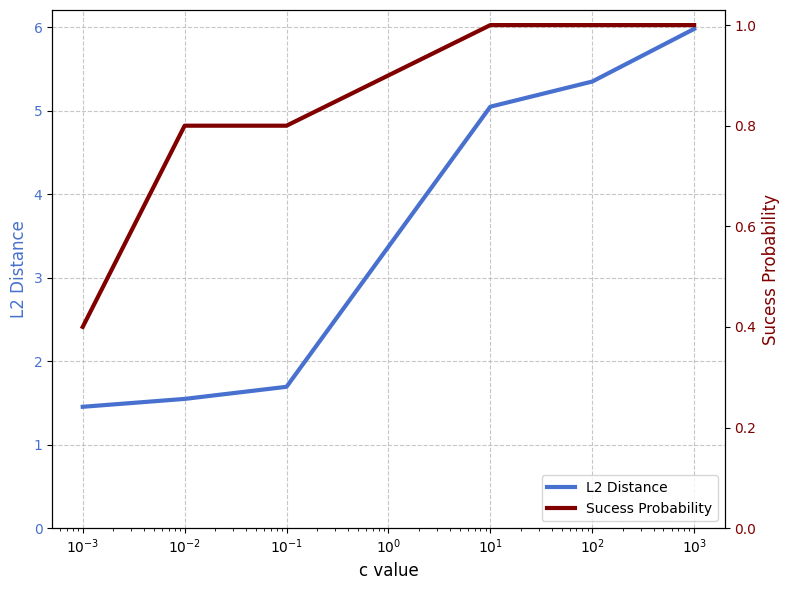

In [23]:
fig, ax1, ax2 = xlab.utils.plot_dual_2d(
    x=list(c_values_to_l2_sum.keys()), 
    y1=list(c_values_to_l2_sum.values()), 
    y2=list(c_values_to_prob.values()),
    y1_label='L2 Distance',
    y2_label='Sucess Probability',
    x_label='c value',
    y1_axis_label='L2 Distance',
    y2_axis_label='Sucess Probability',
    log_x=True,
)

### What do these results mean?

This shows that there is some tradeoff between $L_2$ distance and the probability of attack success. Perhaps an even better way to think about this is there is a tradeoff between how close an image is to it's original and how easily one can fool the model.

So if there is some kind of tradeoff present, how do we choose the best value for $c$? The author's make the following claim (note that $x^{*}$ is a notation for the adversarial example):

<blockquote>
    Empirically, we have found that often the best way to choose
$c$ is to use the smallest value of $c$ for which the resulting
solution $x^{*}$ has $f(x^{*}
)\leq 0$. This causes gradient descent to
minimize both of the terms simultaneously instead of picking
only one to optimize over first.
</blockquote>


In the paper the author's use a modified binary search to find this value of $c$. For brevity we leave this as an excercise to the reader but would not expect this to be too difficult to program. For our purposes, we observe that given a reasonable number of iterations in the $L_2$ setting, $c=0.015$ gives a high probability of success and undetectable perturbations in the $L_2$ setting.

## Task 6-7: Change of variables

If you have not already read [our writeup for Carlini-Wagner attacks](https://xlabaisecurity.com/adversarial/cw/) on our website we highly recommend you do so now. Here is where things start to get tricky.

So far we have been thinking about adversarial examples as $x$ (the original image) plus a set of perturbations $\delta$ bounded by some $L_p$ norm. The issue is that $x + \delta$ can be greater than 1 or less than 0 which would make it an invalid image. Therefore, Carlini and Wagner propose writing $x + \delta$ as a function of a new variable $w$ where $f(w)$ is always between zero and one. Here is the equation they proposed:

$$
x_i + \delta_i = \frac{1}{2} (\tanh({w_i}) + 1)
$$

### Task #6: Caclculate $x + \delta$ given $w$

In task #6, you will calculate the above equation element-wise to find tensor $x + \delta$ given a tensor $w$.

In [94]:
x_clean = x_test[0:1].to(device)

adv_image = cw_simple(f6, x_clean, 1, 100, model, 50)

iteration 5:	 loss=16.3431
iteration 10:	 loss=17.3085
iteration 15:	 loss=17.8474
iteration 20:	 loss=18.0310
iteration 25:	 loss=17.9607
iteration 30:	 loss=17.7223
iteration 35:	 loss=17.3782
iteration 40:	 loss=16.9716
iteration 45:	 loss=16.5308
iteration 50:	 loss=16.0749


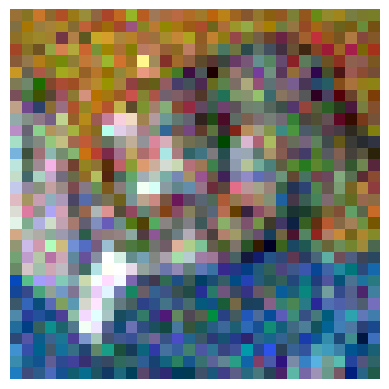

In [95]:
show_image(adv_image.cpu())

In [96]:
distance(adv_image, x_clean, 2).item()

5.565356731414795

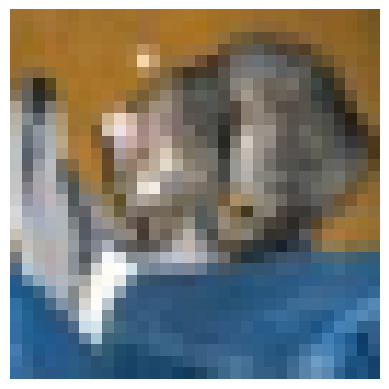

In [73]:
show_image(x_clean.cpu())

In [66]:
def show_image(img):
    """
    Display image tensor using plt
    
    Parameters:
    -----------
    img : Tensor
        image Tensor to be displayed
    """
    img = img.squeeze(0)
    plt.imshow(img.permute(1, 2, 0).detach().numpy())
    plt.axis('off')  # Remove both axes entirely

In [25]:
adv = adv[0].detach().cpu()
x = x_test[0].detach().cpu()
delta = adv - x

_ = xlab.utils.plot_tensors(
    [delta[0], delta[1], delta[2], x.cpu()[0], x.cpu()[1], x.cpu()[2]],
    log_scale=False, 
    ncols=3,
    # log_scale=True,
    titles = ["out delta (red)", "out delta (green)", "out delta (blue)", "image (red)", "image (green)", "image (blue)"]
)

NameError: name 'adv' is not defined

In [300]:
torch.argmax(model(adv))

RuntimeError: slow_conv2d_forward_mps: input(device='cpu') and weight(device=mps:0')  must be on the same device

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.050887734..1.0007143].


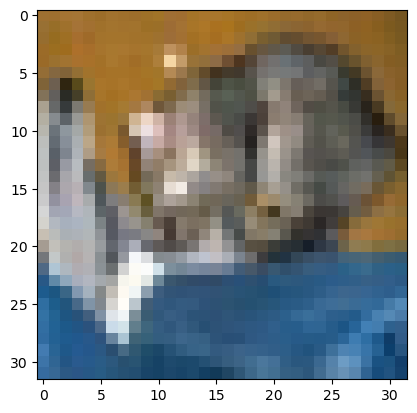

In [283]:
plt.imshow(adv[0].detach().cpu().permute(1,2,0))

In [ ]:
F.cross_entropy(torch.tensor([1.0, 2, 3]), torch.tensor(1))

In [135]:
torch.log(F.softmax(torch.tensor([1.0, 2, 3]), dim=0))

tensor([-2.4076, -1.4076, -0.4076])

$$
f_1(x_{\mathrm{adversarial}}) = -C(F(x_{\mathrm{adversarial}})) + 1
$$

In [2]:
model = load_model(model_name='Standard', threat_model='Linf')
model = model.to('mps')
_ = model.eval()

In [3]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 36,479,194


In [4]:
NUM_EXAMPLES = 100
x_test, y_test = load_cifar10(n_examples=NUM_EXAMPLES)
x_test, y_test = x_test.to(device), y_test.to(device)
print(f"{x_test.shape=}, {y_test.shape=}")

x_test.shape=torch.Size([100, 3, 32, 32]), y_test.shape=torch.Size([100])


In [152]:
def f_6(logits, target, k=0):
    i_neq_t = torch.argmax(logits)
    if i_neq_t == target:
        i_neq_t = torch.argmax(torch.cat([logits[:target], logits[target+1:]]))
    print("in f6", (logits[i_neq_t] - logits[target]).item())
    return torch.max(logits[i_neq_t] - logits[target], -torch.tensor(k))
            

def CW_targeted_l2(img, model, c, target, k=1):
    
    cw_weights = torch.randn_like(img).to('mps') * 0.001
    cw_weights.requires_grad = True
    optimizer = optim.Adam([cw_weights], lr=5e-2)

    num_iters = 100
    delta = 0.5 * (F.tanh(cw_weights) + 1) - img

    k = 0.1

    for i in range(num_iters):
        
        logits = model((img + delta).unsqueeze(0))

        if torch.argmax(logits[0]) == target and torch.sum((delta)**2) <= 0.5:
            return delta

        # print(f_6(logits[0], target))
        assert f_6(logits[0], target, k) >= -k
        success_loss = c * f_6(logits[0], target, k)
        l2_reg = torch.sum((delta)**2)

        loss = success_loss + l2_reg
        print(loss, success_loss, l2_reg)
        
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        delta = 0.5 * (F.tanh(cw_weights) + 1) - img
    print("warning! targeted attack was not successful")
    return delta

In [153]:
torch.max(torch.tensor(5), torch.tensor(-2))

tensor(5)

In [154]:
x = x_test[0]

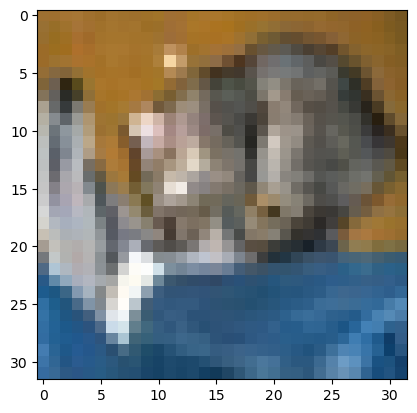

In [155]:
plt.imshow(x.permute(1,2,0).cpu())

In [156]:
out_delta = CW_targeted_l2(x.to('mps'), model, 0.01, 1)

in f6 7.889273643493652
in f6 7.889273643493652
tensor(120.1354, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0789, device='mps:0', grad_fn=<MulBackward0>) tensor(120.0565, device='mps:0', grad_fn=<SumBackward0>)
in f6 8.08248233795166
in f6 8.08248233795166
tensor(97.0092, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0808, device='mps:0', grad_fn=<MulBackward0>) tensor(96.9284, device='mps:0', grad_fn=<SumBackward0>)
in f6 14.96743392944336
in f6 14.96743392944336
tensor(77.6946, device='mps:0', grad_fn=<AddBackward0>) tensor(0.1497, device='mps:0', grad_fn=<MulBackward0>) tensor(77.5449, device='mps:0', grad_fn=<SumBackward0>)
in f6 4.813962936401367
in f6 4.813962936401367
tensor(61.6276, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0481, device='mps:0', grad_fn=<MulBackward0>) tensor(61.5795, device='mps:0', grad_fn=<SumBackward0>)
in f6 1.4890851974487305
in f6 1.4890851974487305
tensor(48.6323, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0149, device='mps:0', gra

In [157]:
out_delta.shape

torch.Size([3, 32, 32])

In [158]:
8/255

0.03137254901960784

In [159]:
out_delta.min(), out_delta.max()

(tensor(-0.0629, device='mps:0', grad_fn=<MinBackward1>),
 tensor(0.0464, device='mps:0', grad_fn=<MaxBackward1>))

In [160]:
max_diff = torch.max(torch.abs(out_delta))

In [161]:
max_diff

tensor(0.0629, device='mps:0', grad_fn=<MaxBackward1>)

In [119]:
assert max_diff < 8/255

Now let's plot what we have. You should 

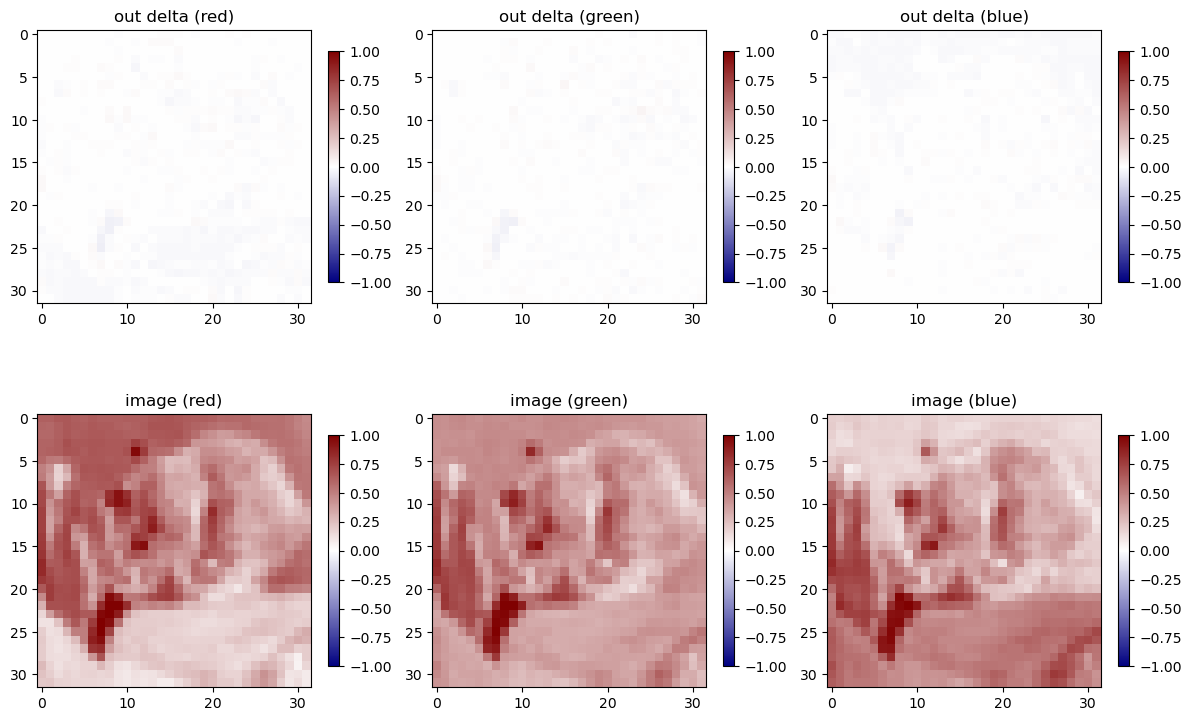

In [162]:
out_delta = out_delta.detach().cpu()

_ = xlab.utils.plot_tensors(
    [out_delta[0], out_delta[1], out_delta[2], x.cpu()[0], x.cpu()[1], x.cpu()[2]],
    log_scale=False, 
    ncols=3,
    # log_scale=True,
    titles = ["out delta (red)", "out delta (green)", "out delta (blue)", "image (red)", "image (green)", "image (blue)"]
)

In [43]:
x_adv = out_delta + x

In [44]:
model(x_adv.unsqueeze(0))

tensor([[13.4251, -0.7176, -1.3678,  3.0889, -5.2713, -1.6484, -1.6464, -2.5078,
         -1.8055, -1.4932]], device='mps:0', grad_fn=<LinearBackward0>)

In [45]:
x_adv.shape

torch.Size([3, 32, 32])

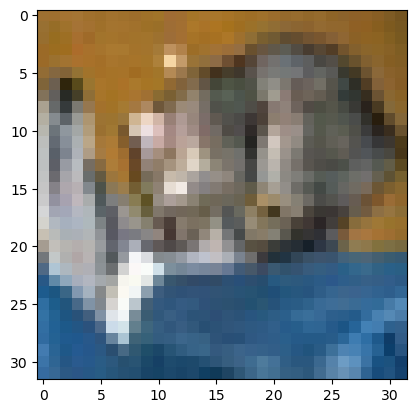

In [46]:
plt.imshow(x_adv.detach().permute(1,2,0).cpu())

## Choosing a constant $c$


<blockquote>
    Empirically, we have found that often the best way to choose
$c$ is to use the smallest value of $c$ for which the resulting
solution $x^{*}$ has $f(x^{*}
)\leq 0$. This causes gradient descent to
minimize both of the terms simultaneously instead of picking
only one to optimize over first.
</blockquote>



On choosing a good $f$:

<blockquote>
The choice of method
for handling box constraints does not impact the quality of
results as significantly for the best minimization functions.
</blockquote>